In [ ]:
!pip install scikit-learn==0.24.1

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
from sklearn.metrics import accuracy_score
print(sklearn.__version__)

0.24.1


In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/temp')
!ls

Mounted at /content/gdrive
automl	checkpoint.h5  dishImages


In [ ]:
# unzip the dataset ,chage the path you want
!unzip -O big5 /content/gdrive/MyDrive/Data.zip
!ls

Archive:  /content/gdrive/MyDrive/Data.zip
replace dishImages/咖哩雞/22000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
automl	checkpoint.h5  dishImages


In [ ]:
base_dir = 'dishImages/'
img_height = 224
img_width = 224
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory ( 
    base_dir,
    validation_split = 0.2,
    subset="training",
    seed = 0, 
    image_size=(img_height, img_width),
    batch_size=batch_size
    )
val_ds = tf.keras.preprocessing.image_dataset_from_directory ( 
    base_dir,
    validation_split = 0.2,
    subset="validation",
    seed = 0, 
    image_size=(img_height, img_width),
    batch_size=batch_size
)
class_names = train_ds.class_names
print(class_names)

Found 385 files belonging to 4 classes.
Using 308 files for training.
Found 385 files belonging to 4 classes.
Using 77 files for validation.
['咖哩雞', '芥藍菜', '關東煮', '雞塊']


In [ ]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

# 從 Google API 上下載字體放到暫存資料夾底下
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -o NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

# 指定字體
font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
  font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"


--2021-06-13 11:33:04--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 173.194.203.128, 2607:f8b0:400e:c05::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M  61.3MB/s    in 1.9s    

2021-06-13 11:33:06 (61.3 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]

Archive:  NotoSansCJKtc-hinted.zip
  inflating: /tmp/fonts/LICENSE_OFL.txt  
  inflating: /tmp/fonts/NotoSansCJKtc-Black.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Bold.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-DemiLight.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Light.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Medium.otf  
  inflatin

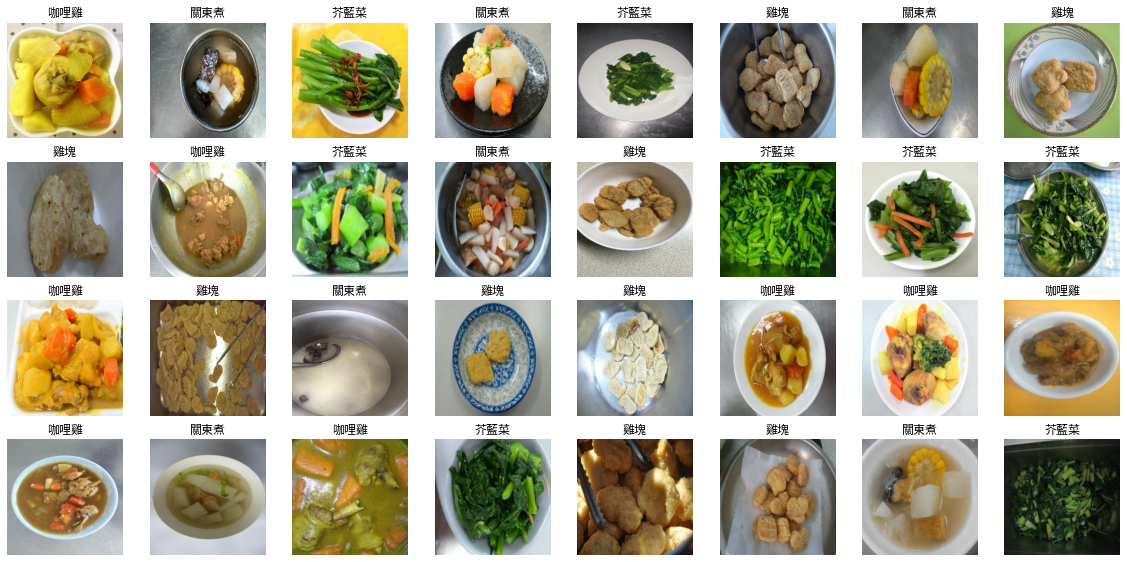

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(32):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
# Data input pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


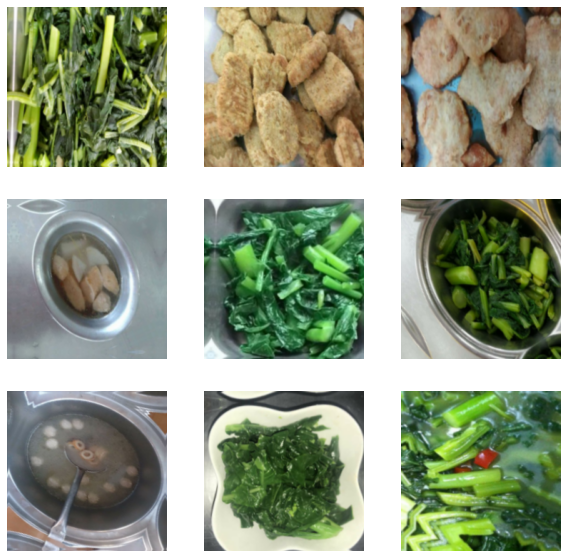

In [ ]:
# Keras preprocessing layers
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = tf.keras.Sequential(
  [
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    image = tf.expand_dims(images[i].numpy().astype("uint8"), 0)
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")



In [ ]:
# import EfficientNetV2 
!pip install tensorflow_addons
import sys

# Download source code.
if "efficientnetv2" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientnetv2')
  sys.path.append('.')
else:
  !git pull

     |████████████████████████████████| 686kB 7.5MB/s 
fatal: destination path 'automl' already exists and is not an empty directory.


In [ ]:
import effnetv2_model
CLASS_NUM = 4
# Edited to include required session clear
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    preprocessing.Rescaling(1./255),
    effnetv2_model.get_model('efficientnetv2-b0', include_top=False, pretrained=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])


105644032/105641003 [==============================] - 1s 0us/step
Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy',
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5 accuracy")]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetv2-b0 (EffNetV2M (None, 1280)              5919312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 5,924,436
Trainable params: 5,863,828
Non-trainable params: 60,608
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_filepath = 'checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_weights_only=True,
    save_best_only = True
  )

In [ ]:
os.chdir('/content/gdrive/MyDrive/temp')
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback,model_checkpoint_callback]
)


Epoch 1/10
10/10 [==============================] - 3s 211ms/step - loss: 0.4417 - accuracy: 0.8214 - top5 accuracy: 1.0000 - val_loss: 0.9375 - val_accuracy: 0.7792 - val_top5 accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 3s 211ms/step - loss: 0.4267 - accuracy: 0.8182 - top5 accuracy: 1.0000 - val_loss: 0.8353 - val_accuracy: 0.7403 - val_top5 accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 3s 212ms/step - loss: 0.4935 - accuracy: 0.8214 - top5 accuracy: 1.0000 - val_loss: 0.8452 - val_accuracy: 0.7662 - val_top5 accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 3s 211ms/step - loss: 0.4673 - accuracy: 0.8442 - top5 accuracy: 1.0000 - val_loss: 0.4431 - val_accuracy: 0.8701 - val_top5 accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 3s 214ms/step - loss: 0.3370 - accuracy: 0.8864 - top5 accuracy: 1.0000 - val_loss: 0.7131 - val_accuracy: 0.8052 - val_top5 accuracy: 1.0000
Epoch 6/10
10/10 [============

    0.893  雞塊
    0.091  咖哩雞
    0.014  關東煮
    0.001  芥藍菜


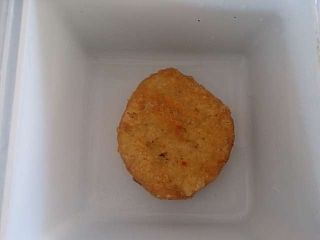

In [ ]:
lab_rand = class_names[np.random.randint(0,4)] #50種挑其中一類
testdir = os.path.join(base_dir,lab_rand) #選出所在種類的資料路徑
#選出其中一張照片的路徑
testimg=os.path.join(testdir,os.listdir(testdir)
                     [np.random.randint(0,len(testdir)-1)])	
x = tf.keras.preprocessing.image.load_img(testimg,target_size=(img_height,img_width))
#模型輸出種類及預測機率 top-5
x = np.expand_dims(x, axis = 0) 
pred = model.predict(x)[0]
top_inds = pred.argsort()[::-1][:4]
for i in top_inds:
  print('    {:.3f}  {}'.format(pred[i], class_names[i]))
from IPython import display
display.display(display.Image(testimg))

In [ ]:
model.load_weights("checkpoint.h5")
